In [264]:
import numpy as np
np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

array([[ 2.0000000e+00,  1.5063980e+02,  7.0831540e+02,  8.6102000e+00,
         7.0826300e+02],
       [ 3.0000000e+00,  9.0218050e+02,  5.6531410e+02,  9.6361000e+00,
         5.6523200e+02],
       [ 4.0000000e+00,  7.3036260e+02,  4.7193240e+02,  1.0191700e+01,
         4.7182240e+02],
       ...,
       [ 1.1980000e+03,  2.3221509e+03,  5.7266724e+03,  5.7264931e+03,
         4.5311600e+01],
       [ 1.1990000e+03, -4.8733315e+03,  5.7751737e+03,  5.7749969e+03,
         4.5209300e+01],
       [ 1.2000000e+03,  7.1949780e+03,  5.8113539e+03,  5.8111797e+03,
         4.5007800e+01]])

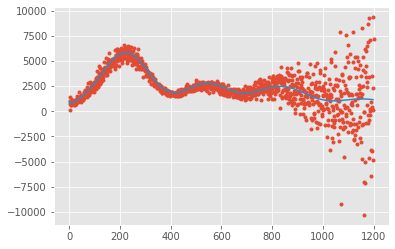

In [265]:
import numpy as np

import corner
import camb


from matplotlib import pyplot as plt


import time








def get_spectrum(pars,lmax=1199):


    #print('pars are ',pars)


    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    tt=tt[2:]

    return tt








plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')





plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum(pars)


plt.plot(cmb)






Using Guassian uncorrelated errors what is chi-squared for these parameters

In [274]:
powe=wmap[:,1]
err=wmap[:,2]

resid = cmb-powe
mean= np.mean(cmb)
std= np.std(cmb)
rms=np.sqrt(np.mean((resid)**2))



    
noise = np.random.normal(mean,std, len(powe))

new_chisq=np.sum((resid)**2/err**2)

print('the chi-squared is', new_chisq)

the chi-squared is 1588.43666423561


# Question 2:

In [277]:
#making a function ot claculate the derivatives in order to use a levenberg marquardt minimizer

def get_derivs(pars,lmax=1199):

    H0, ombh2, omch2, As, ns = pars
    tau=0.05
    
    #creating the delta between steps as the 1/100th of the paramter itself
    delta=pars/100
    
    cmb=get_spectrum([H0, ombh2, omch2, tau, As, ns])
    
    #getting the spectrum with delta added to each parameter individually in order to take a 
    #double sided derivative
    
    cmb_d0=get_spectrum([H0+delta[0],ombh2,omch2,tau,As,ns])
    cmb_d0_neg=get_spectrum([H0-delta[0],ombh2,omch2,tau,As,ns])
    
    cmb_d1=get_spectrum([H0,ombh2+delta[1],omch2,tau,As,ns])
    cmb_d1_neg=get_spectrum([H0,ombh2-delta[1],omch2,tau,As,ns])
    
    cmb_d2=get_spectrum([H0,ombh2,omch2+delta[2],tau,As,ns])
    cmb_d2_neg=get_spectrum([H0,ombh2,omch2-delta[2],tau,As,ns])
    
    cmb_d3=get_spectrum([H0,ombh2,omch2,tau,As+delta[3],ns])
    cmb_d3_neg=get_spectrum([H0,ombh2,omch2,tau,As-delta[3],ns])
    
    cmb_d4=get_spectrum([H0,ombh2,omch2,tau,As,ns+delta[4]])
    cmb_d4_neg=get_spectrum([H0,ombh2,omch2,tau,As,ns-delta[4]])
    
    
    
    #taking the double sided derivative for each of the parameters 
    derivs = np.zeros([len(powe),len(pars)])
    derivs[:,0]=(cmb_d0-cmb_d0_neg)/(2*delta[0])
    derivs[:,1]=(cmb_d1-cmb_d1_neg)/(2*delta[1])
    derivs[:,2]=(cmb_d2-cmb_d2_neg)/(2*delta[2])
    derivs[:,3]=(cmb_d3-cmb_d3_neg)/(2*delta[3])
    derivs[:,4]=(cmb_d4-cmb_d4_neg)/(2*delta[4])

    
    

    return cmb, derivs


#creating a function to update lambda for levenberg-marquardt
def update_lmda(lmda, success):
    if success == False:
        if lmda == 0:
            lmda = 1
        else:
            lmda = 0.5*lmda
    else:
        if lmda < 0.1:
            lmda = 0
        else:
            lmda = lmda/2
    return lmda




In [284]:
pars=np.asarray([65,0.02,0.1,2e-9,0.96])

#intializing lambdaa and setting a chi-sqaured threshold
lmda=0
chisq_thr=1
#calculating the inverse noise matrix
Ninv = np.linalg.inv(np.diag(err))

#getting an initial guess for chi squared
cmb, derivs=get_derivs(pars)
resid=powe-cmb
chisq = np.sum((resid/err)**2)
print('Initial guess for chi-squared',chisq)

#taking ten steps order to minimize chi-squared with lm

chisq_vec=[]
for i in range(10):
    
    deriv_tran=derivs.transpose()
    grad= 2.*np.dot(deriv_tran,np.dot(Ninv,resid)) #gradient of chi squared
    curve=2.*np.dot(deriv_tran,np.dot(Ninv, derivs))
    curve = curve + lmda*np.diag(np.diag(curve))
    
    covar=np.linalg.inv(curve)
    
    
    dpar=np.dot(covar,grad)
    
    new_pars=pars+dpar
    new_fun,new_derivs=get_derivs(new_pars)
    new_resid=powe-new_fun
    new_chisq=np.sum(new_resid**2/err**2)
    
    delt_chisq=new_chisq-chisq
    print('Step '+repr(i+1)+': chi-squared change = '+repr(delt_chisq))
    chisq_vec.append(chisq)
    #accepting the step if chi-squared improves and updating our lamba
    if new_chisq <= chisq:
        resid = new_resid
        chisq = new_chisq
        derivs = new_derivs
        pars = new_pars
        lmba = update_lmda(lmda, success=True)
        print('Update lambda to ',lmda)
        #if chisq is small enough stop
        #if lmda == 0 and np.abs(delt_chisq) < chisq_thr and i > 0:
          #  print('Stopping after ', i, ' iterations.')
          #  break
    else:
        #reject if chi squared does not improve and update the lambda to take another step
        lmda = update_lmda(lmda, success=False)
        print('Rejected. Update lambda to ',lmda)


print('the new chisq is', chisq)
print('the new parameters are', pars)
print('the errors are', np.diag(covar))

Initial guess for chi-squared 1588.43666423561
Step 1: chi-squared change = -349.59871918373983
Update lambda to  0
Step 2: chi-squared change = -9.907986272861763
Update lambda to  0
Step 3: chi-squared change = -0.026555554348988153
Update lambda to  0
Step 4: chi-squared change = -0.0015822971593024704
Update lambda to  0
Step 5: chi-squared change = -5.66311355214566e-05
Update lambda to  0
Step 6: chi-squared change = 6.4421760725963395e-06
Rejected. Update lambda to  1
Step 7: chi-squared change = 3.253267095715273e-07
Rejected. Update lambda to  0.5
Step 8: chi-squared change = -8.571892067266162e-07
Update lambda to  0.5
Step 9: chi-squared change = 8.350772986887023e-06
Rejected. Update lambda to  0.25
Step 10: chi-squared change = 1.0598670996841975e-05
Rejected. Update lambda to  0.125
the new chisq is 1228.9017634391753
the new parameters are [6.78498847e+01 2.24732722e-02 1.16406548e-01 2.06068076e-09
 9.68557542e-01]
the errors are [1.05132194e-03 1.40421109e-10 2.3734505

Text(0, 0.5, 'Chi-Squared')

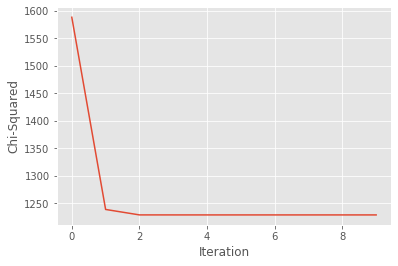

In [288]:
#we can see the derivatives are a good estimate as the chi squared goes down but by less each time
#as the fit gets better and better

plt.plot(chisq_vec)
plt.xlabel('Iteration')
plt.ylabel('Chi-Squared')

We see that the derivatives are a good estimate as the chi squared continues to get better with each step but by a smaller amount as the fit becomes more accurate and harder to improve.

We can not repeat the same LM process but this time only allow tau to float. The new errors are expected to be different due to the addition of the tau which changes the covariance matrix. If we were to float all 6 parameters the errors would be larger as the covariance matrix would have to take in the error on tau as well.

In [305]:
#this function gets the derivatives for tau setting all the parameters as were found earlier
#and floating tau


def get_derivs_mcmc(pars,lmax=1199):

    H0, ombh2, omch2, As, ns = np.asarray([6.78498847e+01,2.24732722e-02,1.16406548e-01,2.06068076e-09,9.68557542e-01])
    tau=pars
    delta=pars/100
    
    cmb=get_spectrum([H0, ombh2, omch2, tau, As, ns])

    
    cmb_d5=get_spectrum([H0, ombh2, omch2, tau+delta, As, ns])
    cmb_d5_neg=get_spectrum([H0, ombh2, omch2, tau-delta, As, ns])
    
    derivs = np.zeros([len(powe),1])

    derivs[:,0]=(cmb_d5-cmb_d5_neg)/(2*delta)

    
    
    

    return cmb, derivs

In [308]:
#doing the same as before but this time allowing tau to float and setting the other parameters
pars=0.05

lmda=0
chisq_thr=1
Ninv = np.linalg.inv(np.diag(err**2))

cmb, derivs=get_derivs_mcmc(pars)
resid=powe-cmb
chisq = np.sum((resid/err)**2)
print('Initial guess: chi-squared = '+repr(chisq))


for i in range(10):
    deriv_tran=derivs.transpose()
    grad= 2.*np.dot(deriv_tran,np.dot(Ninv,resid)) #gradient of chi squared
    curve=2.*np.dot(deriv_tran,np.dot(Ninv, derivs))
    curve = curve + lmda*np.diag(np.diag(curve))
    
    covar=np.linalg.inv(curve)
    
            #a by the diagonal of the curvature rather than the identity matrix 
    dpar=np.dot(covar,grad)
    
    new_pars=pars+dpar
    new_fun,new_derivs=get_derivs_mcmc(new_pars)
    new_resid=powe-new_fun
    new_chisq=np.sum(new_resid**2/err**2)
    
    delt_chisq=new_chisq-chisq
    print('Step '+repr(i+1)+': chi-squared change = '+repr(delt_chisq))
    
    
    if new_chisq <= chisq:
        resid = new_resid
        chisq = new_chisq
        derivs = new_derivs
        pars = new_pars
        lmba = update_lmda(lmda, success=True)
        #print('Updating lambda to '+repr(lmda)+'.')
        #if lmda == 0 and np.abs(delt_chisq) < chisq_thr and i > 0:
            #print('Stopping after ', i, ' iterations.')
            #break
    else:
        lmda = update_lmda(lmda, success=False)
        print('Reject! Updating lambda to ',lmda)


print('the updated chisq is', chisq)
print('the updated tau is', pars)
print('the error is', np.diag(covar))

Initial guess: chi-squared = 1228.9017646672237
Step 1: chi-squared change = -0.024722655999084964
Step 2: chi-squared change = -6.722075340803713e-09
Step 3: chi-squared change = 0.0
Step 4: chi-squared change = 0.0
Step 5: chi-squared change = 0.0
Step 6: chi-squared change = -2.2737367544323206e-13
Step 7: chi-squared change = 6.821210263296962e-13
Reject! Updating lambda to  1
Step 8: chi-squared change = 0.0
Step 9: chi-squared change = 0.0
Step 10: chi-squared change = 0.0
the updated chisq is 1228.8770420045023
the updated tau is [0.05028839]
the errors is [8.41306645e-07]


# Question 3:

We can not use a markov chain to fit with the 6 paramters given

In [262]:
#using the initial guess parameters
#getting the covariance
covar=np.diag(np.asarray[1.05132194e-03, 1.40421109e-10, 2.37345051e-09, 8.41306645e-07, 1.77159567e-25
 ,5.89602400e-08])

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#function to take a step drawing using the cholesky of the covariance matrix calculated in
#the previous question
def take_step_cov(covar):
    mychol=np.linalg.cholesky(covar)
    return np.dot(mychol,np.random.randn(covar.shape[0]))





nstep=1000
#keep track of where the chain goes
chains=np.zeros([nstep,len(pars)]) 
#keep track of the chisq's
chisqvec=np.zeros(nstep)


npar=len(pars)
chains_new=np.zeros([nstep,npar])



chisq=np.sum((powe-get_spectrum(pars))**2/((err**2)))
scale_fac=1

#this paramter will be used to keep track of how many steps are accepted
numaccept=0

for i in range(nstep):
    #print('for the', i,'iteration the parameters are', pars)
    
        
    #print(pars[3])
    step=take_step_cov(np.diag(np.diag(covar)))*scale_fac      
    #print(step)
    new_pars=pars+step
    
    #if the optical depth is negative pass it
    if new_pars[3]<=0:
        pass
    else:
        total_iter.append(i)
        new_model=get_spectrum(new_pars)
        new_chisq=np.sum((powe-new_model)**2/(err**2))
        delta_chisq=new_chisq-chisq
        prob=np.exp(-1.5*delta_chisq)
        accept=np.random.rand(1)<prob
        #accept all steps if chi-squared improves and only some otherwise
        if accept:
            pars=new_pars
            model=new_model
            chisq=new_chisq
            numaccept+=1
    chains_new[i,:]=pars
    chisqvec_new[i]=chisq

#saving the chains to a file
np.savetxt("chains_output",chains_new)

#calculate the number accepted 
print('the percentage accepted is',(numaccept/nstep)*100)
fit_params=np.mean(chains_new,axis=0)
print('the parameters are',fit_params)





for the 0 th iteration the parameters are [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
0.05
[ 7.39524707e-01 -3.75063853e-05 -6.17319978e-04 -9.06410137e-04
 -3.75582046e-12 -1.11669026e-03]
for the 1 th iteration the parameters are [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
0.05
[ 4.85526759e-01  1.05256012e-04  6.05637013e-04 -1.37432343e-03
  1.63233232e-12  2.16948846e-03]
for the 2 th iteration the parameters are [6.54855268e+01 2.01052560e-02 1.00605637e-01 4.86256766e-02
 2.00163233e-09 9.62169488e-01]
0.04862567657346439
[-4.66557620e-01 -3.05615809e-04  5.21157607e-04 -1.94519237e-04
  1.41159923e-12 -1.93599200e-03]
for the 3 th iteration the parameters are [6.54855268e+01 2.01052560e-02 1.00605637e-01 4.86256766e-02
 2.00163233e-09 9.62169488e-01]
0.04862567657346439
[ 3.93858190e-02 -1.63884993e-04 -6.08310283e-05 -1.08118735e-04
 -9.10022878e-12  1.39846832e-03]
for the 4 th iteration the parameters are [6.55249126e+01 1.99413710e-02 1.00544806e-01 4.85175578e-

for the 33 th iteration the parameters are [6.71353887e+01 1.97485216e-02 1.01784810e-01 6.71722538e-02
 1.99586362e-09 9.56489732e-01]
0.06717225381621757
[ 4.36915100e-01 -1.81764625e-04  2.70860394e-04 -5.03978756e-05
  3.40056215e-12 -3.10725882e-04]
for the 34 th iteration the parameters are [6.71353887e+01 1.97485216e-02 1.01784810e-01 6.71722538e-02
 1.99586362e-09 9.56489732e-01]
0.06717225381621757
[ 8.20180272e-01 -3.95778987e-05 -3.20909157e-04 -1.82061037e-03
  4.77547907e-12 -2.48398089e-03]
for the 35 th iteration the parameters are [6.71353887e+01 1.97485216e-02 1.01784810e-01 6.71722538e-02
 1.99586362e-09 9.56489732e-01]
0.06717225381621757
[-1.69713677e-01 -1.19962574e-04 -4.27422600e-04 -1.23141112e-03
 -9.78399301e-12 -4.15638011e-03]
for the 36 th iteration the parameters are [6.71353887e+01 1.97485216e-02 1.01784810e-01 6.71722538e-02
 1.99586362e-09 9.56489732e-01]
0.06717225381621757
[ 2.76619006e-01 -2.74155005e-04 -1.47794226e-04  2.59030881e-04
  1.76297936e-

for the 66 th iteration the parameters are [6.93955504e+01 2.00773861e-02 1.03413346e-01 7.04274181e-02
 2.00179739e-09 9.47295934e-01]
0.07042741807869665
[ 2.56947845e-01 -1.16102727e-04 -5.56843221e-05 -4.97028136e-04
 -1.60325781e-12  4.72526068e-03]
for the 67 th iteration the parameters are [6.93955504e+01 2.00773861e-02 1.03413346e-01 7.04274181e-02
 2.00179739e-09 9.47295934e-01]
0.07042741807869665
[ 2.52765121e-01 -2.70107963e-04  7.48820928e-04  8.43088122e-04
 -2.62571310e-12 -3.55604577e-03]
for the 68 th iteration the parameters are [6.93955504e+01 2.00773861e-02 1.03413346e-01 7.04274181e-02
 2.00179739e-09 9.47295934e-01]
0.07042741807869665
[ 2.43433124e-01  8.78408569e-05  3.20213718e-04  1.11732773e-03
  3.90482455e-12 -8.05108795e-04]
for the 69 th iteration the parameters are [6.96389836e+01 2.01652269e-02 1.03733559e-01 7.15447458e-02
 2.00570221e-09 9.46490826e-01]
0.07154474580935055
[-9.76521485e-01  1.56128495e-05  3.38429028e-05  1.04541514e-04
 -9.84239918e-

for the 99 th iteration the parameters are [6.94965829e+01 2.11935385e-02 1.04903805e-01 6.68259337e-02
 2.00887061e-09 9.53941112e-01]
0.06682593369850821
[ 6.74992448e-02  1.55760513e-05 -4.37244409e-05  4.71155485e-04
 -1.65539092e-12 -1.81332013e-03]
for the 100 th iteration the parameters are [6.95640822e+01 2.12091145e-02 1.04860081e-01 6.72970892e-02
 2.00721522e-09 9.52127792e-01]
0.06729708918333084
[-3.31461847e-01  7.77400711e-05  7.35478644e-05 -1.52555811e-03
 -1.21351856e-13  5.04732908e-03]
for the 101 th iteration the parameters are [6.95640822e+01 2.12091145e-02 1.04860081e-01 6.72970892e-02
 2.00721522e-09 9.52127792e-01]
0.06729708918333084
[-9.93946986e-02 -1.95551731e-06  3.34034304e-05 -1.76503560e-04
 -2.82317029e-12 -5.11950215e-04]
for the 102 th iteration the parameters are [6.94646875e+01 2.12071590e-02 1.04893484e-01 6.71205856e-02
 2.00439205e-09 9.51615842e-01]
0.06712058562382463
[ 2.02097709e-01  9.83268798e-05  3.03614238e-04 -2.96486858e-04
  1.1381227

for the 131 th iteration the parameters are [7.09731576e+01 2.14945899e-02 1.04991328e-01 6.05438601e-02
 1.98706577e-09 9.53727112e-01]
0.06054386007305572
[-3.62979692e-02  3.35020484e-04  2.19720686e-04 -3.07631996e-03
  1.55616309e-12 -5.65524143e-05]
for the 132 th iteration the parameters are [7.09731576e+01 2.14945899e-02 1.04991328e-01 6.05438601e-02
 1.98706577e-09 9.53727112e-01]
0.06054386007305572
[ 9.16148320e-02 -3.27400937e-05  7.10422110e-04  1.44012511e-03
 -1.35799868e-12  5.44443176e-04]
for the 133 th iteration the parameters are [7.09731576e+01 2.14945899e-02 1.04991328e-01 6.05438601e-02
 1.98706577e-09 9.53727112e-01]
0.06054386007305572
[-2.25344132e-01  7.45588029e-05 -2.17021942e-04 -6.46863433e-04
 -5.78057963e-12 -5.31625481e-04]
for the 134 th iteration the parameters are [7.07478135e+01 2.15691487e-02 1.04774306e-01 5.98969966e-02
 1.98128519e-09 9.53195486e-01]
0.05989699664043497
[-1.05301272e+00 -1.62337147e-04  6.47863812e-05  9.95264026e-04
  2.061929

for the 163 th iteration the parameters are [7.07185505e+01 2.17539553e-02 1.05464866e-01 5.92920717e-02
 1.99647003e-09 9.60745725e-01]
0.059292071696460696
[-6.63798558e-01  1.38924068e-04 -3.13789270e-04 -1.06267050e-03
  4.45696199e-12  1.85095103e-03]
for the 164 th iteration the parameters are [7.07185505e+01 2.17539553e-02 1.05464866e-01 5.92920717e-02
 1.99647003e-09 9.60745725e-01]
0.059292071696460696
[ 3.96482861e-01 -1.96871754e-05  2.48479488e-05  5.54837162e-04
  2.12663885e-12  4.07453956e-03]
for the 165 th iteration the parameters are [7.07185505e+01 2.17539553e-02 1.05464866e-01 5.92920717e-02
 1.99647003e-09 9.60745725e-01]
0.059292071696460696
[ 6.11055662e-01  8.52033849e-05  3.22351506e-04  4.35123544e-04
 -2.31666751e-12 -1.21818581e-03]
for the 166 th iteration the parameters are [7.07185505e+01 2.17539553e-02 1.05464866e-01 5.92920717e-02
 1.99647003e-09 9.60745725e-01]
0.059292071696460696
[-2.89168671e-01 -1.36820385e-04 -3.45418508e-04  6.10502547e-04
  2.95

for the 195 th iteration the parameters are [7.09521142e+01 2.23191451e-02 1.06680433e-01 6.02549672e-02
 2.01615184e-09 9.65122111e-01]
0.06025496724477744
[ 1.33884657e-01  3.35507456e-05  5.22143016e-04 -6.84513031e-04
  5.53988854e-12  1.46789852e-04]
for the 196 th iteration the parameters are [7.10859988e+01 2.23526958e-02 1.07202576e-01 5.95704542e-02
 2.02169173e-09 9.65268901e-01]
0.059570454213335074
[ 1.49672621e-01  1.47877192e-04  1.42494198e-04  2.49276779e-04
 -5.06003203e-12  5.16209055e-04]
for the 197 th iteration the parameters are [7.10859988e+01 2.23526958e-02 1.07202576e-01 5.95704542e-02
 2.02169173e-09 9.65268901e-01]
0.059570454213335074
[-5.00234865e-01  6.53618787e-05 -2.35043509e-04  6.80394438e-04
  1.19724280e-12  3.92112928e-03]
for the 198 th iteration the parameters are [7.05857640e+01 2.24180577e-02 1.06967532e-01 6.02508487e-02
 2.02288897e-09 9.69190030e-01]
0.060250848651478305
[ 6.45675094e-01  2.44800302e-04 -8.25103974e-04 -1.53315703e-03
 -5.192

for the 227 th iteration the parameters are [7.28440554e+01 2.24789951e-02 1.06303103e-01 6.43044299e-02
 2.04444685e-09 9.78799223e-01]
0.0643044299465812
[-7.55703876e-02  1.49511960e-04  4.46320210e-04  8.91316369e-04
 -3.78885417e-13 -2.30036101e-03]
for the 228 th iteration the parameters are [7.27684850e+01 2.26285070e-02 1.06749423e-01 6.51957463e-02
 2.04406796e-09 9.76498862e-01]
0.06519574631508639
[-2.66080347e-01  2.69735026e-05  3.19600698e-04  1.61614658e-04
  4.96607034e-12 -3.15239976e-03]
for the 229 th iteration the parameters are [7.25024046e+01 2.26554805e-02 1.07069024e-01 6.53573610e-02
 2.04903403e-09 9.73346463e-01]
0.06535736097280737
[ 5.05446448e-01 -1.53047747e-04  7.36514673e-04  2.97614711e-06
  3.28174774e-12 -2.96325184e-03]
for the 230 th iteration the parameters are [7.25024046e+01 2.26554805e-02 1.07069024e-01 6.53573610e-02
 2.04903403e-09 9.73346463e-01]
0.06535736097280737
[-4.26190175e-01 -2.88750971e-05  6.93093349e-04  1.47045540e-04
  4.1920466

for the 260 th iteration the parameters are [7.13476124e+01 2.25454391e-02 1.07785766e-01 6.30300489e-02
 2.04839200e-09 9.69543622e-01]
0.06303004888512327
[ 3.05435827e-01  9.74234449e-06  6.85197390e-04  2.40190073e-04
 -9.84025709e-12 -4.59895420e-03]
for the 261 th iteration the parameters are [7.13476124e+01 2.25454391e-02 1.07785766e-01 6.30300489e-02
 2.04839200e-09 9.69543622e-01]
0.06303004888512327
[ 9.97110506e-02  1.31967675e-06  4.74132865e-04  2.32564785e-03
 -8.18466942e-12 -3.68422413e-03]
for the 262 th iteration the parameters are [7.13476124e+01 2.25454391e-02 1.07785766e-01 6.30300489e-02
 2.04839200e-09 9.69543622e-01]
0.06303004888512327
[-4.87169052e-01 -2.21862874e-04  4.02395459e-04 -1.94326237e-03
  2.56575984e-12  1.10353722e-03]
for the 263 th iteration the parameters are [7.13476124e+01 2.25454391e-02 1.07785766e-01 6.30300489e-02
 2.04839200e-09 9.69543622e-01]
0.06303004888512327
[ 4.03345239e-01  2.47527033e-05  2.09836929e-04 -3.50480219e-03
 -6.580917

for the 293 th iteration the parameters are [7.17622313e+01 2.30476533e-02 1.08944814e-01 6.06526970e-02
 2.05395934e-09 9.79481905e-01]
0.06065269701063685
[-2.47591448e-01  1.79434056e-04 -5.72031940e-04  3.43955188e-04
  8.25311935e-12  2.73817539e-03]
for the 294 th iteration the parameters are [7.17622313e+01 2.30476533e-02 1.08944814e-01 6.06526970e-02
 2.05395934e-09 9.79481905e-01]
0.06065269701063685
[-2.14797293e-01 -5.63514770e-05 -3.01896971e-04  8.60416687e-04
  3.76835685e-12 -1.46805964e-03]
for the 295 th iteration the parameters are [7.17622313e+01 2.30476533e-02 1.08944814e-01 6.06526970e-02
 2.05395934e-09 9.79481905e-01]
0.06065269701063685
[-1.37789117e-01 -1.04865096e-04 -3.17872156e-04 -5.35737730e-04
  1.13336606e-12  1.00784539e-03]
for the 296 th iteration the parameters are [7.16244422e+01 2.29427882e-02 1.08626942e-01 6.01169593e-02
 2.05509270e-09 9.80489750e-01]
0.060116959280670644
[-2.79822755e-01 -1.08689145e-04  4.51330633e-04  7.40895997e-04
  8.93144

for the 325 th iteration the parameters are [7.10571313e+01 2.25900411e-02 1.10132567e-01 5.69979972e-02
 2.04040040e-09 9.72499969e-01]
0.056997997187682725
[ 2.48370255e-03 -9.17233313e-05  1.12125975e-03  5.40493836e-04
 -5.66985656e-12 -2.92269145e-03]
for the 326 th iteration the parameters are [7.10571313e+01 2.25900411e-02 1.10132567e-01 5.69979972e-02
 2.04040040e-09 9.72499969e-01]
0.056997997187682725
[ 1.82856925e-01 -1.35019774e-04 -1.60467547e-05  1.03364349e-03
 -2.50090369e-12 -1.62350393e-03]
for the 327 th iteration the parameters are [7.10571313e+01 2.25900411e-02 1.10132567e-01 5.69979972e-02
 2.04040040e-09 9.72499969e-01]
0.056997997187682725
[ 4.49732125e-02  2.27538630e-04 -5.57571150e-05  6.71928793e-04
  5.19078221e-12  2.76227092e-03]
for the 328 th iteration the parameters are [7.11021045e+01 2.28175798e-02 1.10076810e-01 5.76699260e-02
 2.04559118e-09 9.75262240e-01]
0.05766992598078326
[-1.11094931e-01 -5.52503483e-05  2.93282836e-04  1.36266764e-03
  4.101

for the 357 th iteration the parameters are [7.03196304e+01 2.25267526e-02 1.10668681e-01 5.84180774e-02
 2.05133262e-09 9.77711538e-01]
0.058418077371267904
[-2.17109590e-01  6.09652396e-05 -4.33676958e-04  1.35243040e-03
 -2.14764669e-12  7.75418596e-03]
for the 358 th iteration the parameters are [7.03196304e+01 2.25267526e-02 1.10668681e-01 5.84180774e-02
 2.05133262e-09 9.77711538e-01]
0.058418077371267904
[ 4.76003464e-01 -1.20658879e-04  3.63194438e-04 -3.86904160e-04
 -1.02181097e-12 -3.09271980e-05]
for the 359 th iteration the parameters are [7.03196304e+01 2.25267526e-02 1.10668681e-01 5.84180774e-02
 2.05133262e-09 9.77711538e-01]
0.058418077371267904
[ 1.73924197e-01  1.54046737e-04 -2.49739227e-04  1.59908981e-03
 -4.20581582e-12 -3.25596747e-03]
for the 360 th iteration the parameters are [7.03196304e+01 2.25267526e-02 1.10668681e-01 5.84180774e-02
 2.05133262e-09 9.77711538e-01]
0.058418077371267904
[ 2.00677505e-01  2.65776166e-04  2.70477927e-04  1.74545733e-03
  2.41

for the 389 th iteration the parameters are [7.18344028e+01 2.29707805e-02 1.10958873e-01 5.28780133e-02
 2.05070071e-09 9.79717675e-01]
0.05287801327186615
[-7.47175180e-02  3.22534295e-05 -3.67043062e-04  1.72774159e-03
  2.77865756e-12  2.29071435e-03]
for the 390 th iteration the parameters are [7.17596853e+01 2.30030339e-02 1.10591830e-01 5.46057549e-02
 2.05347937e-09 9.82008389e-01]
0.0546057548657585
[-7.05703012e-01  5.56126906e-05  8.83704700e-05  7.62480590e-04
 -2.94609401e-12  1.77847321e-03]
for the 391 th iteration the parameters are [7.10539823e+01 2.30586466e-02 1.10680201e-01 5.53682355e-02
 2.05053328e-09 9.83786862e-01]
0.05536823545581206
[ 1.11233813e-01  1.08381539e-04  2.88281152e-04  4.57166428e-04
 -2.77359268e-12 -1.22826992e-03]
for the 392 th iteration the parameters are [7.10539823e+01 2.30586466e-02 1.10680201e-01 5.53682355e-02
 2.05053328e-09 9.83786862e-01]
0.05536823545581206
[-2.08968434e-02  1.80897419e-04  5.53585177e-04 -5.78727044e-04
 -6.4687057

for the 421 th iteration the parameters are [7.02266463e+01 2.27316909e-02 1.12843392e-01 5.26697479e-02
 2.04857358e-09 9.79502596e-01]
0.05266974785086245
[ 4.68055351e-01  1.02213579e-06 -3.56301785e-04 -1.55086220e-03
  2.32412798e-13 -1.23799899e-03]
for the 422 th iteration the parameters are [7.06947017e+01 2.27327130e-02 1.12487090e-01 5.11188857e-02
 2.04880600e-09 9.78264597e-01]
0.05111888565305012
[ 3.33065719e-01 -1.42675297e-04 -1.12595495e-04 -2.22773078e-03
  1.02850694e-11 -3.98340382e-04]
for the 423 th iteration the parameters are [7.06947017e+01 2.27327130e-02 1.12487090e-01 5.11188857e-02
 2.04880600e-09 9.78264597e-01]
0.05111888565305012
[ 1.31517634e-01  1.20530117e-04  1.01769215e-04 -1.96197450e-04
  9.74214842e-12  4.00484434e-03]
for the 424 th iteration the parameters are [7.06947017e+01 2.27327130e-02 1.12487090e-01 5.11188857e-02
 2.04880600e-09 9.78264597e-01]
0.05111888565305012
[ 5.01576430e-01  1.98514204e-04  3.92927442e-04 -9.23949049e-04
  4.460470

for the 454 th iteration the parameters are [6.95228462e+01 2.22879158e-02 1.13142984e-01 5.40053047e-02
 2.05684094e-09 9.71883904e-01]
0.05400530466937926
[-5.42374288e-01 -2.56847361e-04 -2.09253611e-04  6.65080997e-04
  1.75940616e-13 -9.17479374e-04]
for the 455 th iteration the parameters are [6.95228462e+01 2.22879158e-02 1.13142984e-01 5.40053047e-02
 2.05684094e-09 9.71883904e-01]
0.05400530466937926
[-1.71992811e-01 -5.03480527e-05  7.59759908e-04  1.12450341e-03
 -1.45741404e-12  4.13606667e-04]
for the 456 th iteration the parameters are [6.95228462e+01 2.22879158e-02 1.13142984e-01 5.40053047e-02
 2.05684094e-09 9.71883904e-01]
0.05400530466937926
[ 6.10286511e-01  1.59181015e-04 -3.58454703e-04 -3.84672179e-04
 -7.36677584e-12  1.11830285e-03]
for the 457 th iteration the parameters are [7.01331328e+01 2.24470968e-02 1.12784529e-01 5.36206325e-02
 2.04947416e-09 9.73002207e-01]
0.05362063249068402
[ 2.59759780e-01  4.05293260e-05 -2.87393519e-04  1.22177626e-03
 -4.069924

for the 487 th iteration the parameters are [7.05173695e+01 2.31776066e-02 1.13712025e-01 5.44946236e-02
 2.07582104e-09 9.82202508e-01]
0.05449462362676254
[ 6.13885326e-02 -1.76611457e-05 -1.95977260e-04  3.97612461e-04
 -4.33229596e-12 -1.65573371e-04]
for the 488 th iteration the parameters are [7.05787580e+01 2.31599455e-02 1.13516047e-01 5.48922361e-02
 2.07148875e-09 9.82036935e-01]
0.05489223608779706
[ 5.58258419e-01 -1.25470829e-04 -8.33086099e-04 -6.84981250e-04
 -4.67346431e-12  1.86927027e-03]
for the 489 th iteration the parameters are [7.11370165e+01 2.30344747e-02 1.12682961e-01 5.42072548e-02
 2.06681528e-09 9.83906205e-01]
0.05420725483739474
[ 2.62929118e-01 -4.04017192e-05 -5.55678678e-04 -2.03539252e-04
  8.19561219e-13 -1.53458760e-04]
for the 490 th iteration the parameters are [7.13999456e+01 2.29940729e-02 1.12127283e-01 5.40037156e-02
 2.06763484e-09 9.83752747e-01]
0.05400371558557297
[ 1.51502736e-01  8.31100367e-05 -2.98376106e-04 -1.12057915e-03
  3.995247

for the 519 th iteration the parameters are [7.11108194e+01 2.28922172e-02 1.10949143e-01 4.86378176e-02
 2.02820201e-09 9.78323245e-01]
0.04863781764314127
[ 1.64907132e-01  3.89888516e-05 -1.24678706e-03 -1.42164598e-03
  4.07719623e-12 -8.64505742e-04]
for the 520 th iteration the parameters are [7.11108194e+01 2.28922172e-02 1.10949143e-01 4.86378176e-02
 2.02820201e-09 9.78323245e-01]
0.04863781764314127
[ 9.07033343e-01 -1.72357067e-04  3.12595516e-04 -1.01206568e-03
 -1.21022739e-12 -1.91626022e-03]
for the 521 th iteration the parameters are [7.11108194e+01 2.28922172e-02 1.10949143e-01 4.86378176e-02
 2.02820201e-09 9.78323245e-01]
0.04863781764314127
[ 1.68734445e-01 -2.96376499e-05 -1.09446428e-04 -9.61189290e-04
 -1.44803803e-14  2.62764308e-04]
for the 522 th iteration the parameters are [7.11108194e+01 2.28922172e-02 1.10949143e-01 4.86378176e-02
 2.02820201e-09 9.78323245e-01]
0.04863781764314127
[-3.14345243e-01 -2.07781135e-04  7.08439314e-04  9.10551905e-04
  6.563510

for the 552 th iteration the parameters are [7.03392666e+01 2.27554814e-02 1.14487009e-01 4.90058587e-02
 2.05482144e-09 9.80107983e-01]
0.04900585867149447
[ 2.26893947e-01 -1.11338309e-04  3.92014709e-05  7.84415812e-04
  7.43063346e-16  7.63155271e-04]
for the 553 th iteration the parameters are [7.03392666e+01 2.27554814e-02 1.14487009e-01 4.90058587e-02
 2.05482144e-09 9.80107983e-01]
0.04900585867149447
[-4.34405584e-01 -8.41206468e-05 -3.00699076e-04  3.42495669e-04
  5.39103666e-12  1.85841085e-03]
for the 554 th iteration the parameters are [7.03392666e+01 2.27554814e-02 1.14487009e-01 4.90058587e-02
 2.05482144e-09 9.80107983e-01]
0.04900585867149447
[-2.50838455e-02  7.20236473e-05 -1.32303571e-04  6.20585523e-05
 -4.52075995e-12  2.47572338e-03]
for the 555 th iteration the parameters are [7.03141828e+01 2.28275051e-02 1.14354706e-01 4.90679172e-02
 2.05030068e-09 9.82583707e-01]
0.04906791722375692
[ 1.60131808e-01 -1.14419458e-05 -5.25380228e-04 -2.97455999e-04
 -5.453788

for the 585 th iteration the parameters are [6.88612566e+01 2.25674569e-02 1.13150837e-01 4.82220310e-02
 2.03347822e-09 9.73405349e-01]
0.048222030962133386
[-2.66820775e-01 -1.27520038e-04  7.66309199e-04 -1.09825859e-03
  6.16765177e-12  3.35850589e-03]
for the 586 th iteration the parameters are [6.88612566e+01 2.25674569e-02 1.13150837e-01 4.82220310e-02
 2.03347822e-09 9.73405349e-01]
0.048222030962133386
[ 5.12486152e-01  2.63076187e-05  1.33688874e-04  4.83589090e-04
 -4.45389803e-12  5.08367752e-04]
for the 587 th iteration the parameters are [6.93737428e+01 2.25937645e-02 1.13284526e-01 4.87056201e-02
 2.02902432e-09 9.73913717e-01]
0.04870562005257149
[-8.09920851e-02  1.64226573e-05  6.14358573e-05  4.02301858e-04
  5.46622397e-12 -2.21000033e-03]
for the 588 th iteration the parameters are [6.92927507e+01 2.26101872e-02 1.13345962e-01 4.91079219e-02
 2.03449054e-09 9.71703717e-01]
0.04910792191100543
[ 3.72493706e-01  2.86735505e-05  2.94948608e-04 -2.35507782e-03
 -1.4272

for the 617 th iteration the parameters are [6.97327402e+01 2.23070618e-02 1.12840837e-01 4.96539174e-02
 2.02955026e-09 9.66564871e-01]
0.04965391743118472
[ 1.23857073e-01 -1.44353353e-04 -1.03711169e-03  9.22225531e-04
  1.85256433e-12 -2.17004807e-03]
for the 618 th iteration the parameters are [6.97327402e+01 2.23070618e-02 1.12840837e-01 4.96539174e-02
 2.02955026e-09 9.66564871e-01]
0.04965391743118472
[ 6.09413414e-01 -5.38601533e-05 -3.77625503e-04 -6.29028070e-04
  1.18525288e-13 -3.51577933e-03]
for the 619 th iteration the parameters are [6.97327402e+01 2.23070618e-02 1.12840837e-01 4.96539174e-02
 2.02955026e-09 9.66564871e-01]
0.04965391743118472
[-4.31544261e-01 -6.88321007e-05  2.77298891e-04  8.96682702e-04
  7.82057420e-12  1.78118189e-03]
for the 620 th iteration the parameters are [6.93011959e+01 2.22382297e-02 1.13118136e-01 5.05506001e-02
 2.03737083e-09 9.68346053e-01]
0.050550600133286536
[ 6.54691075e-02  1.24481236e-04  6.65239388e-04 -7.88475237e-04
 -1.82260

for the 649 th iteration the parameters are [7.04408771e+01 2.26685072e-02 1.11980210e-01 5.34263353e-02
 2.04035972e-09 9.74717822e-01]
0.053426335325926534
[-1.49283907e-01 -1.08581975e-04 -3.20475801e-04  7.73954012e-04
  1.65909773e-12 -7.49814134e-03]
for the 650 th iteration the parameters are [7.04408771e+01 2.26685072e-02 1.11980210e-01 5.34263353e-02
 2.04035972e-09 9.74717822e-01]
0.053426335325926534
[ 1.87640156e-01  1.23057426e-05 -3.52720872e-04 -1.20467633e-03
 -2.99039035e-12 -8.88190880e-04]
for the 651 th iteration the parameters are [7.06285173e+01 2.26808129e-02 1.11627489e-01 5.22216590e-02
 2.03736933e-09 9.73829631e-01]
0.05222165899889786
[-1.52391410e-01  3.26436505e-04 -1.99504802e-04  5.30121264e-04
 -4.09161234e-12  2.91334051e-03]
for the 652 th iteration the parameters are [7.06285173e+01 2.26808129e-02 1.11627489e-01 5.22216590e-02
 2.03736933e-09 9.73829631e-01]
0.05222165899889786
[-2.32614219e-01 -6.83480583e-05 -1.97104173e-04 -1.00590309e-03
  2.9717

for the 681 th iteration the parameters are [6.95391769e+01 2.24745840e-02 1.11167790e-01 5.20160925e-02
 2.03043948e-09 9.75005316e-01]
0.05201609247777455
[ 4.37192326e-01  2.08534292e-04 -6.24378216e-04 -1.67289545e-03
 -7.08429153e-13 -6.61294349e-04]
for the 682 th iteration the parameters are [6.95391769e+01 2.24745840e-02 1.11167790e-01 5.20160925e-02
 2.03043948e-09 9.75005316e-01]
0.05201609247777455
[ 6.36532627e-01 -7.45757838e-05  9.10376186e-04  8.66618576e-05
 -1.86067270e-12  2.04092545e-03]
for the 683 th iteration the parameters are [6.95391769e+01 2.24745840e-02 1.11167790e-01 5.20160925e-02
 2.03043948e-09 9.75005316e-01]
0.05201609247777455
[-1.36626424e-01 -1.27841646e-04 -4.43604313e-04  2.23983560e-05
  9.27520447e-12  1.24605269e-03]
for the 684 th iteration the parameters are [6.95391769e+01 2.24745840e-02 1.11167790e-01 5.20160925e-02
 2.03043948e-09 9.75005316e-01]
0.05201609247777455
[-8.51236039e-02  1.91843922e-04  8.46927962e-05  5.46152153e-04
 -5.028114

for the 713 th iteration the parameters are [7.10934273e+01 2.28316305e-02 1.10515671e-01 5.38452073e-02
 2.03568371e-09 9.69861758e-01]
0.053845207283166885
[ 4.77698909e-01  1.17420926e-04 -8.57102074e-04 -1.93297201e-03
  3.92033528e-12  1.93254385e-03]
for the 714 th iteration the parameters are [7.10934273e+01 2.28316305e-02 1.10515671e-01 5.38452073e-02
 2.03568371e-09 9.69861758e-01]
0.053845207283166885
[-6.45704253e-02  8.98531106e-05 -3.00873547e-04  1.06011478e-03
  5.96071446e-12  2.22514353e-03]
for the 715 th iteration the parameters are [7.10288568e+01 2.29214836e-02 1.10214798e-01 5.49053221e-02
 2.04164442e-09 9.72086901e-01]
0.05490532206782669
[-2.80521139e-01 -5.60393339e-05  2.26493779e-04 -1.86270044e-03
 -5.56952218e-12 -3.95535976e-03]
for the 716 th iteration the parameters are [7.10288568e+01 2.29214836e-02 1.10214798e-01 5.49053221e-02
 2.04164442e-09 9.72086901e-01]
0.05490532206782669
[-2.19673519e-01  2.85605565e-05 -8.02180225e-05 -1.38013352e-03
 -5.2553

for the 746 th iteration the parameters are [7.06968893e+01 2.28928867e-02 1.11545180e-01 5.19920656e-02
 2.03039053e-09 9.71274915e-01]
0.05199206556624801
[-8.18391298e-01  3.05188435e-06 -6.78085427e-04 -1.86356899e-04
 -8.71046712e-12  1.40349103e-03]
for the 747 th iteration the parameters are [7.06968893e+01 2.28928867e-02 1.11545180e-01 5.19920656e-02
 2.03039053e-09 9.71274915e-01]
0.05199206556624801
[-4.83377058e-01 -3.30259424e-06 -1.32618493e-05 -6.17170268e-04
 -7.03331361e-12 -8.90693064e-04]
for the 748 th iteration the parameters are [7.06968893e+01 2.28928867e-02 1.11545180e-01 5.19920656e-02
 2.03039053e-09 9.71274915e-01]
0.05199206556624801
[-4.07683422e-01 -1.31311976e-04 -7.27859017e-04 -1.17399736e-03
  2.81919298e-13 -7.81396026e-04]
for the 749 th iteration the parameters are [7.06968893e+01 2.28928867e-02 1.11545180e-01 5.19920656e-02
 2.03039053e-09 9.71274915e-01]
0.05199206556624801
[-1.40690586e-01 -1.98999566e-04  3.14617708e-04  1.50371886e-03
 -5.745716

for the 779 th iteration the parameters are [7.17815872e+01 2.28947104e-02 1.09743353e-01 5.37839602e-02
 2.02560637e-09 9.72389802e-01]
0.053783960194398406
[ 1.11698026e-01  1.95696843e-05 -4.35751636e-04  4.83446459e-04
  4.92712744e-12 -2.44637188e-03]
for the 780 th iteration the parameters are [7.17815872e+01 2.28947104e-02 1.09743353e-01 5.37839602e-02
 2.02560637e-09 9.72389802e-01]
0.053783960194398406
[ 3.17172890e-02 -6.69498446e-05  9.18006262e-04  2.28468983e-04
  2.19701813e-12  1.05954927e-03]
for the 781 th iteration the parameters are [7.17815872e+01 2.28947104e-02 1.09743353e-01 5.37839602e-02
 2.02560637e-09 9.72389802e-01]
0.053783960194398406
[ 1.73936490e-01 -1.20840031e-04  9.80189820e-05 -1.06184930e-03
  4.41828654e-13 -1.82118220e-04]
for the 782 th iteration the parameters are [7.19555237e+01 2.27738704e-02 1.09841372e-01 5.27221109e-02
 2.02604820e-09 9.72207684e-01]
0.05272211089701463
[ 6.58479429e-01 -2.80495135e-05 -5.12122680e-04  8.54863279e-04
  3.145

for the 811 th iteration the parameters are [7.11933423e+01 2.27198785e-02 1.10821150e-01 5.04956633e-02
 2.03026632e-09 9.75971713e-01]
0.0504956633487784
[-1.77614569e-01 -3.43542341e-05 -4.81183557e-04  1.02776365e-03
  8.78440284e-13 -2.67299278e-03]
for the 812 th iteration the parameters are [7.11933423e+01 2.27198785e-02 1.10821150e-01 5.04956633e-02
 2.03026632e-09 9.75971713e-01]
0.0504956633487784
[-2.44721773e-01  1.06213195e-04  2.83823203e-04  3.82259689e-04
 -7.78677205e-12 -1.09949463e-03]
for the 813 th iteration the parameters are [7.09486205e+01 2.28260917e-02 1.11104973e-01 5.08779230e-02
 2.02247955e-09 9.74872218e-01]
0.05087792303821485
[-4.81896325e-01 -2.82069045e-04  6.14563982e-06 -1.60816659e-05
  1.58806321e-12 -8.67200438e-04]
for the 814 th iteration the parameters are [7.04667242e+01 2.25440227e-02 1.11111119e-01 5.08618414e-02
 2.02406761e-09 9.74005018e-01]
0.05086184137236217
[ 8.97259830e-02  9.20665848e-05 -3.75403184e-04  1.38776039e-03
  5.60894985

for the 844 th iteration the parameters are [7.02974410e+01 2.23101366e-02 1.09332382e-01 5.50231561e-02
 2.02469136e-09 9.71790718e-01]
0.0550231560842767
[-2.04634208e-01 -1.35142506e-04 -8.32153378e-05 -7.34198406e-04
  6.49455276e-12 -1.15058661e-03]
for the 845 th iteration the parameters are [7.02974410e+01 2.23101366e-02 1.09332382e-01 5.50231561e-02
 2.02469136e-09 9.71790718e-01]
0.0550231560842767
[ 2.65630543e-01  7.64921177e-06  2.94175923e-04  2.83859989e-04
 -7.03953390e-12  2.34588062e-03]
for the 846 th iteration the parameters are [7.02974410e+01 2.23101366e-02 1.09332382e-01 5.50231561e-02
 2.02469136e-09 9.71790718e-01]
0.0550231560842767
[-5.27901150e-01 -1.82870059e-05 -7.59886294e-04  1.81097986e-04
  4.63188584e-12 -2.42212645e-03]
for the 847 th iteration the parameters are [7.02974410e+01 2.23101366e-02 1.09332382e-01 5.50231561e-02
 2.02469136e-09 9.71790718e-01]
0.0550231560842767
[-1.06691616e-01 -7.24161029e-05 -1.95511282e-04  2.02156315e-04
  4.64055932e-

for the 876 th iteration the parameters are [7.03936456e+01 2.26148417e-02 1.11148153e-01 4.92596359e-02
 2.02090385e-09 9.72852792e-01]
0.0492596359241323
[ 4.79967750e-01 -7.14338202e-05 -1.09575184e-03 -2.49031637e-04
 -1.59526526e-12  1.17341448e-03]
for the 877 th iteration the parameters are [7.03936456e+01 2.26148417e-02 1.11148153e-01 4.92596359e-02
 2.02090385e-09 9.72852792e-01]
0.0492596359241323
[-3.42404861e-01  2.96335486e-05 -4.47352239e-04 -1.53229592e-03
 -1.86490367e-12 -1.03535057e-03]
for the 878 th iteration the parameters are [7.03936456e+01 2.26148417e-02 1.11148153e-01 4.92596359e-02
 2.02090385e-09 9.72852792e-01]
0.0492596359241323
[-6.23426384e-01  8.75690297e-05  8.17505069e-05 -4.93564136e-04
  1.10809207e-11  3.99367429e-03]
for the 879 th iteration the parameters are [7.03936456e+01 2.26148417e-02 1.11148153e-01 4.92596359e-02
 2.02090385e-09 9.72852792e-01]
0.0492596359241323
[ 2.71737807e-01 -1.36345593e-04  3.56848101e-04  7.74526331e-04
 -7.06008081e-

for the 908 th iteration the parameters are [7.08744392e+01 2.27665532e-02 1.10997658e-01 4.73077231e-02
 2.00669398e-09 9.66092837e-01]
0.04730772308703679
[-6.80099790e-01 -2.39109722e-05  3.79742755e-04  1.96219675e-03
 -3.63450122e-12 -5.56541752e-04]
for the 909 th iteration the parameters are [7.08744392e+01 2.27665532e-02 1.10997658e-01 4.73077231e-02
 2.00669398e-09 9.66092837e-01]
0.04730772308703679
[9.86606347e-02 7.14362307e-05 2.40641746e-04 2.16140905e-03
 4.27084512e-12 2.43443707e-03]
for the 910 th iteration the parameters are [7.08744392e+01 2.27665532e-02 1.10997658e-01 4.73077231e-02
 2.00669398e-09 9.66092837e-01]
0.04730772308703679
[-2.28757376e-01  1.64564855e-04  2.86655187e-04 -2.11437453e-04
 -5.37614590e-12  1.48056142e-03]
for the 911 th iteration the parameters are [7.08744392e+01 2.27665532e-02 1.10997658e-01 4.73077231e-02
 2.00669398e-09 9.66092837e-01]
0.04730772308703679
[ 1.16674624e-01  2.28391533e-04 -4.92990464e-04 -8.89406475e-04
 -4.91031438e-12

for the 941 th iteration the parameters are [7.02680875e+01 2.23879115e-02 1.11386906e-01 4.69566207e-02
 2.00504548e-09 9.65765487e-01]
0.04695662073676559
[ 2.31415957e-02 -2.04638894e-04  1.32501908e-05  8.37700235e-04
  8.38444003e-12  9.32639729e-04]
for the 942 th iteration the parameters are [7.02680875e+01 2.23879115e-02 1.11386906e-01 4.69566207e-02
 2.00504548e-09 9.65765487e-01]
0.04695662073676559
[-1.30078264e-01  1.60716733e-04 -4.82469314e-04  8.63819878e-04
  4.43815792e-13  4.22151458e-03]
for the 943 th iteration the parameters are [7.02680875e+01 2.23879115e-02 1.11386906e-01 4.69566207e-02
 2.00504548e-09 9.65765487e-01]
0.04695662073676559
[-1.54085965e-01 -1.45599078e-04 -1.44981764e-05  1.01470036e-03
 -1.65370078e-12 -2.17296916e-03]
for the 944 th iteration the parameters are [7.01140016e+01 2.22423124e-02 1.11372408e-01 4.79713211e-02
 2.00339178e-09 9.63592518e-01]
0.0479713211001587
[5.17825385e-01 5.71967638e-06 3.59748382e-04 5.19423435e-04
 2.58943841e-12

for the 974 th iteration the parameters are [7.04732588e+01 2.23427792e-02 1.11274197e-01 4.66302403e-02
 2.00007906e-09 9.65836804e-01]
0.04663024032008145
[ 3.07411694e-01 -3.99467624e-05 -8.02326007e-04  9.62821071e-04
 -2.52750973e-12 -1.69019099e-03]
for the 975 th iteration the parameters are [7.07806704e+01 2.23028324e-02 1.10471871e-01 4.75930614e-02
 1.99755155e-09 9.64146613e-01]
0.047593061390926845
[-4.48185609e-02  1.73813244e-04 -1.82211602e-04 -2.67594759e-04
  4.03820975e-12  5.34736768e-04]
for the 976 th iteration the parameters are [7.07358519e+01 2.24766457e-02 1.10289660e-01 4.73254666e-02
 2.00158976e-09 9.64681350e-01]
0.04732546663203897
[-2.41684438e-01  7.73770476e-05  2.84661048e-04  7.69826706e-04
 -8.41427917e-12  6.93885942e-04]
for the 977 th iteration the parameters are [7.07358519e+01 2.24766457e-02 1.10289660e-01 4.73254666e-02
 2.00158976e-09 9.64681350e-01]
0.04732546663203897
[-3.43218535e-01  4.39266614e-05  1.12707682e-04  6.50185941e-04
  3.47335

In [269]:
print('the percentage accepted is',(numaccept/nstep)*100)
fit_params=np.mean(chains_new,axis=0)
print('the parameters are',fit_params)

the percentage accepted is 37.5
the parameters are [7.04314110e+01 2.23026597e-02 1.09600051e-01 5.52706488e-02
 2.02864885e-09 9.70960142e-01]


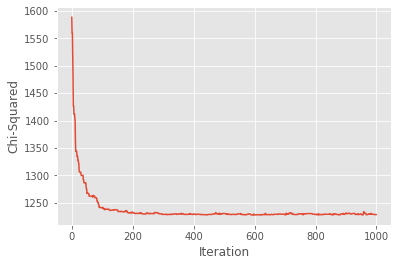

the final chi-sqaured is 1228.7454323333718


<Figure size 432x288 with 0 Axes>

In [270]:
#plotting the chi squared to see if it goes down

plt.plot(chisqvec_new)
plt.xlabel("Iteration")
plt.ylabel('Chi-Squared')
plt.show()
plt.clf()

print('the final chi-sqaured is',chisqvec_new[-1])

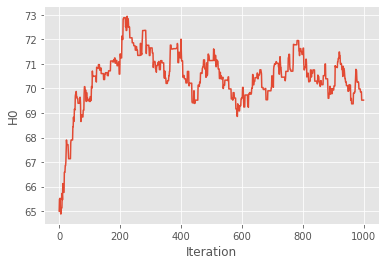

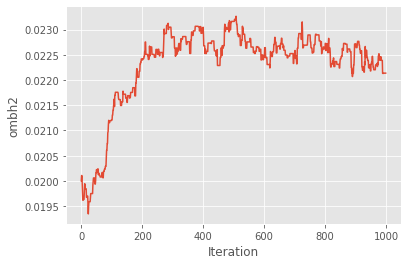

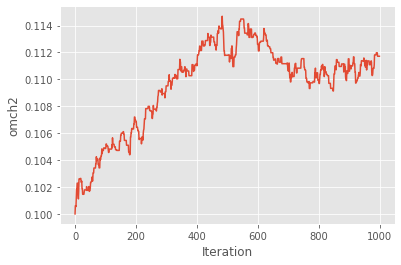

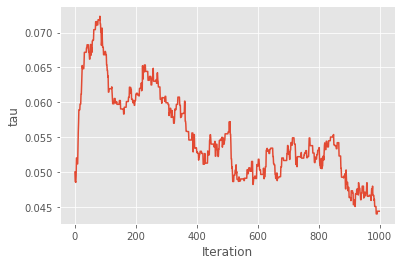

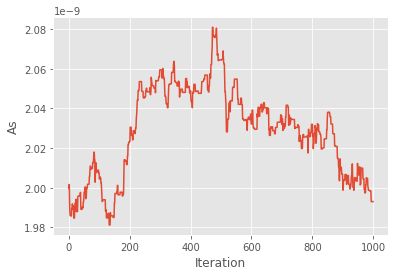

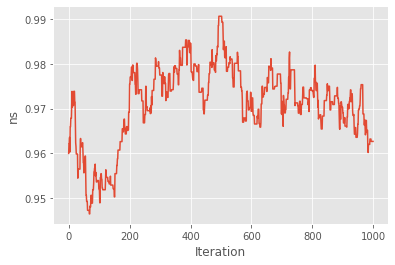

In [271]:
plt.figure()

plt.plot(chains_new[:,0])
plt.xlabel("Iteration")
plt.ylabel('H0')
plt.show()
plt.clf()
plt.plot(chains_new[:,1])
plt.xlabel("Iteration")
plt.ylabel('ombh2')
plt.show()
plt.clf()
plt.plot(chains_new[:,2])
plt.xlabel("Iteration")
plt.ylabel('omch2')
plt.show()
plt.clf()
plt.plot(chains_new[:,3])
plt.xlabel("Iteration")
plt.ylabel('tau')
plt.show()
plt.clf()
plt.plot(chains_new[:,4])
plt.xlabel("Iteration")
plt.ylabel('As')
plt.show()
plt.clf()
plt.plot(chains_new[:,5])
plt.xlabel("Iteration")
plt.ylabel('ns')
plt.show()

From these graphs it is not entirely clear that the parameters are converging however it does seem like they are fluctuating less the farther the chain goes and they therefore may be converging at a value. I was only able to take 1000 points so perhaps with more points the convergance would be clearer.

# Question 4:

First I will add the prior by weighting each of the parameters with the accepted tau. To do this we multiply each by a factor of $ e^{-0.5((\tau-0.0544)/0.0073)^2}$ and use this as our weight. I then run the MCMC again by adding the prior and changing our chi squared such that tau will not deviate too far from the accepted value.

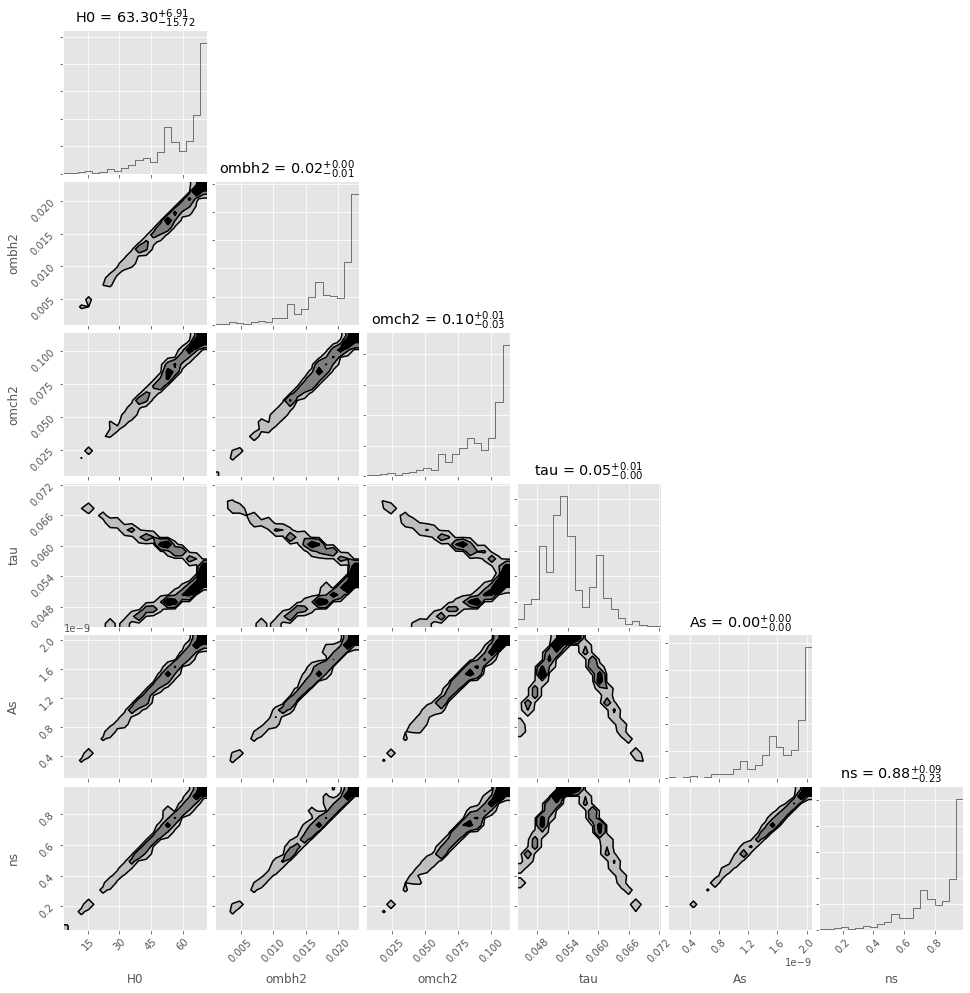

In [310]:



# Extracting the chain results
pars = np.loadtxt("chains_output", usecols = (0,1,2,3,4,5),unpack=True)

#setting the paramters
H0,ombh2,omch2,tau,As,ns = pars

H0_wei = H0*np.exp(-0.5*((tau-0.0544)/0.0073)**2)
ombh2_wei = ombh2*np.exp(-0.5*((tau-0.0544)/0.0073)**2)
omch2_wei = omch2*np.exp(-0.5*((tau-0.0544)/0.0073)**2)
tau_wei = tau
As_wei = As*np.exp(-0.5*((tau-0.0544)/0.0073)**2)
ns_wei = ns*np.exp(-0.5*((tau-0.0544)/0.0073)**2)
weis = np.exp(-0.5*((tau-0.0544)/0.0073)**2)
pars = np.asarray([H0_wei,ombh2_wei,omch2_wei,tau_wei,As_wei,ns_wei])
wei_pars = pars.T




labels = ["H0","ombh2","omch2","tau","As","ns" ]
#using confidence levels of 68, 90 and 99
levels = (0.68,0.90,0.99)
figure = corner.corner(wei_pars, show_titles=True, labels=labels, weights=weis, fill_contours=True, plot_datapoints=False, levels=levels)







These values seem close to the accepted values, however, they don't seem perfect as there are some strange fluctuations in the trends. 
using this we get

$H_0$ = 63.3 $^{+6.91}_{-15.72}$

$\omega_b h^2$ = 0.020 $^{+0.00}_{-0.001}$

$\omega_c h^2$ = 0.10 $^{+0.01}_{-0.03}$

$\tau$ = 0.05 $^{+0.01}_{-0.00}$

$As$ ~ 2.0 $^{+0.1}_{-0.1}$ $\times 10^{-9}$

$ns$ = 0.88 $^{+0.09}_{-0.23}$


Running the chain again but adding the accepted value of tau as a prior. This can be done by changing the chi squared with the weight of the tau accepted.

In [297]:
#all the same as before but adding the tau as a prior by adding the weight to the chi squared

numaccept=0


pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])



#x=np.linspace(-1,1,1000)


nstep=1000

chains=np.zeros([nstep,len(pars)]) #keep track of where the chain went
chisqvec=np.zeros(nstep)

npar=len(pars)
chains_new=np.zeros([nstep,npar])



chisq=np.sum((powe-get_spectrum(pars))**2/((err**2)))
scale_fac=0.5
chisqvec_new=np.zeros(nstep)



for i in range(nstep):
    
    print('for the', i,'th iteration the parameters are', pars)
    
        
    #print(pars[3])                    
    new_pars=pars+take_step_cov(covar)*scale_fac


    total_iter.append(i)
    new_model=get_spectrum(new_pars)
    #here we add the weight to the chi-sqaured 
    new_chisq=np.sum((powe-new_model)**2/(err**2))+((new_pars[3]-0.0544)/0.0073)**2
    delta_chisq=new_chisq-chisq
    prob=np.exp(-0.5*delta_chisq)
    accept=np.random.rand(1)<prob
    if accept:
        pars=new_pars
        model=new_model
        chisq=new_chisq
        numaccept+=1
    chains_new[i,:]=pars
    chisqvec_new[i]=chisq
#saving the values to a text file
np.savetxt("weight_output",chains_new)


fit_params=np.mean(chains_new,axis=0)
print('the new parameters are', fit_params)



for the 0 th iteration the parameters are [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
for the 1 th iteration the parameters are [6.48986935e+01 2.00600456e-02 1.00054678e-01 5.06297728e-02
 2.00267528e-09 9.60411353e-01]
for the 2 th iteration the parameters are [6.53497433e+01 2.01527234e-02 9.97214106e-02 5.09880205e-02
 2.00290872e-09 9.61400860e-01]
for the 3 th iteration the parameters are [6.53497433e+01 2.01527234e-02 9.97214106e-02 5.09880205e-02
 2.00290872e-09 9.61400860e-01]
for the 4 th iteration the parameters are [6.54059642e+01 2.01794563e-02 9.99839362e-02 5.19076845e-02
 2.00901723e-09 9.61847423e-01]
for the 5 th iteration the parameters are [6.54059642e+01 2.01794563e-02 9.99839362e-02 5.19076845e-02
 2.00901723e-09 9.61847423e-01]
for the 6 th iteration the parameters are [6.52901137e+01 2.01824130e-02 1.00054097e-01 5.15656614e-02
 2.00967519e-09 9.63915542e-01]
for the 7 th iteration the parameters are [6.52901137e+01 2.01824130e-02 1.00054097e-01 5.15656614

for the 61 th iteration the parameters are [6.69579901e+01 2.05716092e-02 1.02680036e-01 5.57735635e-02
 1.99853649e-09 9.58007173e-01]
for the 62 th iteration the parameters are [6.69579901e+01 2.05716092e-02 1.02680036e-01 5.57735635e-02
 1.99853649e-09 9.58007173e-01]
for the 63 th iteration the parameters are [6.69579901e+01 2.05716092e-02 1.02680036e-01 5.57735635e-02
 1.99853649e-09 9.58007173e-01]
for the 64 th iteration the parameters are [6.67915772e+01 2.05528497e-02 1.02955635e-01 5.60402346e-02
 1.99718430e-09 9.57086522e-01]
for the 65 th iteration the parameters are [6.67915772e+01 2.05528497e-02 1.02955635e-01 5.60402346e-02
 1.99718430e-09 9.57086522e-01]
for the 66 th iteration the parameters are [6.66892264e+01 2.05156997e-02 1.03155278e-01 5.55910082e-02
 1.99565906e-09 9.55892645e-01]
for the 67 th iteration the parameters are [6.67370719e+01 2.06231760e-02 1.03114027e-01 5.59205662e-02
 1.99702848e-09 9.54777666e-01]
for the 68 th iteration the parameters are [6.67

for the 122 th iteration the parameters are [6.96279836e+01 2.13092148e-02 1.04982649e-01 5.64673740e-02
 1.99795336e-09 9.60993025e-01]
for the 123 th iteration the parameters are [6.96279836e+01 2.13092148e-02 1.04982649e-01 5.64673740e-02
 1.99795336e-09 9.60993025e-01]
for the 124 th iteration the parameters are [6.94655661e+01 2.13945048e-02 1.05120229e-01 5.56035095e-02
 1.99720929e-09 9.62307335e-01]
for the 125 th iteration the parameters are [6.94655661e+01 2.13945048e-02 1.05120229e-01 5.56035095e-02
 1.99720929e-09 9.62307335e-01]
for the 126 th iteration the parameters are [6.95891085e+01 2.13892074e-02 1.05327090e-01 5.60529480e-02
 2.00030810e-09 9.63296183e-01]
for the 127 th iteration the parameters are [6.96715988e+01 2.15164736e-02 1.05261060e-01 5.56563663e-02
 2.00062999e-09 9.64990184e-01]
for the 128 th iteration the parameters are [6.98229302e+01 2.14946667e-02 1.05183251e-01 5.59727723e-02
 2.00053510e-09 9.67370764e-01]
for the 129 th iteration the parameters a

for the 182 th iteration the parameters are [7.06094814e+01 2.24615809e-02 1.07713696e-01 5.67462020e-02
 2.00487600e-09 9.65478764e-01]
for the 183 th iteration the parameters are [7.06094814e+01 2.24615809e-02 1.07713696e-01 5.67462020e-02
 2.00487600e-09 9.65478764e-01]
for the 184 th iteration the parameters are [7.08869793e+01 2.24719298e-02 1.07696207e-01 5.61919022e-02
 2.00401957e-09 9.64892897e-01]
for the 185 th iteration the parameters are [7.10105673e+01 2.24964734e-02 1.07431503e-01 5.52336893e-02
 2.00179304e-09 9.66137592e-01]
for the 186 th iteration the parameters are [7.13983147e+01 2.25195148e-02 1.07480484e-01 5.52139963e-02
 2.00085044e-09 9.65362164e-01]
for the 187 th iteration the parameters are [7.14525528e+01 2.25059409e-02 1.07415918e-01 5.60600580e-02
 1.99966246e-09 9.63124510e-01]
for the 188 th iteration the parameters are [7.12637121e+01 2.23465636e-02 1.07367534e-01 5.65921855e-02
 1.99982775e-09 9.60653017e-01]
for the 189 th iteration the parameters a

for the 242 th iteration the parameters are [7.14690094e+01 2.24315388e-02 1.07903672e-01 5.66021875e-02
 2.01195902e-09 9.74937004e-01]
for the 243 th iteration the parameters are [7.14690094e+01 2.24315388e-02 1.07903672e-01 5.66021875e-02
 2.01195902e-09 9.74937004e-01]
for the 244 th iteration the parameters are [7.13402657e+01 2.25188086e-02 1.07870661e-01 5.68954430e-02
 2.01093847e-09 9.74596841e-01]
for the 245 th iteration the parameters are [7.13402657e+01 2.25188086e-02 1.07870661e-01 5.68954430e-02
 2.01093847e-09 9.74596841e-01]
for the 246 th iteration the parameters are [7.13504925e+01 2.25179465e-02 1.07614795e-01 5.65662413e-02
 2.00671231e-09 9.73851728e-01]
for the 247 th iteration the parameters are [7.13504925e+01 2.25179465e-02 1.07614795e-01 5.65662413e-02
 2.00671231e-09 9.73851728e-01]
for the 248 th iteration the parameters are [7.13941497e+01 2.25418942e-02 1.07761727e-01 5.79181897e-02
 2.00843205e-09 9.73423299e-01]
for the 249 th iteration the parameters a

for the 302 th iteration the parameters are [7.06285468e+01 2.28444001e-02 1.10655085e-01 5.61822317e-02
 2.04061480e-09 9.76792974e-01]
for the 303 th iteration the parameters are [7.09075349e+01 2.28887056e-02 1.10467540e-01 5.61150970e-02
 2.03913013e-09 9.77226432e-01]
for the 304 th iteration the parameters are [7.08944852e+01 2.28942318e-02 1.10451864e-01 5.69959332e-02
 2.04453606e-09 9.77887268e-01]
for the 305 th iteration the parameters are [7.10853786e+01 2.29071595e-02 1.10123166e-01 5.79712069e-02
 2.04652325e-09 9.77536605e-01]
for the 306 th iteration the parameters are [7.12554750e+01 2.29491519e-02 1.10355526e-01 5.76236852e-02
 2.04709505e-09 9.77473535e-01]
for the 307 th iteration the parameters are [7.12748532e+01 2.30835144e-02 1.10540597e-01 5.71991122e-02
 2.04738912e-09 9.76219303e-01]
for the 308 th iteration the parameters are [7.11328208e+01 2.30315151e-02 1.10767474e-01 5.72897028e-02
 2.04496110e-09 9.74915870e-01]
for the 309 th iteration the parameters a

for the 362 th iteration the parameters are [7.04031690e+01 2.21984719e-02 1.09607119e-01 5.93612611e-02
 2.03972655e-09 9.70175913e-01]
for the 363 th iteration the parameters are [7.04031690e+01 2.21984719e-02 1.09607119e-01 5.93612611e-02
 2.03972655e-09 9.70175913e-01]
for the 364 th iteration the parameters are [7.04078794e+01 2.21387793e-02 1.09369817e-01 5.98500851e-02
 2.04157091e-09 9.70244446e-01]
for the 365 th iteration the parameters are [7.04078794e+01 2.21387793e-02 1.09369817e-01 5.98500851e-02
 2.04157091e-09 9.70244446e-01]
for the 366 th iteration the parameters are [7.04615696e+01 2.21614887e-02 1.09464614e-01 5.94238099e-02
 2.04241427e-09 9.69785255e-01]
for the 367 th iteration the parameters are [7.03796457e+01 2.21550069e-02 1.09610101e-01 5.95558625e-02
 2.04624933e-09 9.72374623e-01]
for the 368 th iteration the parameters are [7.04344003e+01 2.22790888e-02 1.09527786e-01 5.90694750e-02
 2.04344396e-09 9.73444347e-01]
for the 369 th iteration the parameters a

for the 422 th iteration the parameters are [6.85086405e+01 2.17169099e-02 1.10613441e-01 5.01506129e-02
 2.01647255e-09 9.62362002e-01]
for the 423 th iteration the parameters are [6.82436176e+01 2.17295234e-02 1.10710080e-01 5.02709169e-02
 2.01882607e-09 9.63073014e-01]
for the 424 th iteration the parameters are [6.82465643e+01 2.17702898e-02 1.10787918e-01 4.97595399e-02
 2.01714316e-09 9.64281653e-01]
for the 425 th iteration the parameters are [6.82465643e+01 2.17702898e-02 1.10787918e-01 4.97595399e-02
 2.01714316e-09 9.64281653e-01]
for the 426 th iteration the parameters are [6.83185167e+01 2.16489293e-02 1.10586924e-01 5.04057688e-02
 2.01670478e-09 9.65015011e-01]
for the 427 th iteration the parameters are [6.81324828e+01 2.17126752e-02 1.10716916e-01 5.02007192e-02
 2.01738179e-09 9.66146310e-01]
for the 428 th iteration the parameters are [6.83776598e+01 2.17031270e-02 1.10767478e-01 4.94738282e-02
 2.01575452e-09 9.65521478e-01]
for the 429 th iteration the parameters a

for the 482 th iteration the parameters are [6.99670818e+01 2.20958660e-02 1.13027621e-01 4.93440565e-02
 2.02659498e-09 9.61635856e-01]
for the 483 th iteration the parameters are [6.97707831e+01 2.20094028e-02 1.12947377e-01 4.97695112e-02
 2.03106924e-09 9.61361374e-01]
for the 484 th iteration the parameters are [6.97707831e+01 2.20094028e-02 1.12947377e-01 4.97695112e-02
 2.03106924e-09 9.61361374e-01]
for the 485 th iteration the parameters are [6.97707831e+01 2.20094028e-02 1.12947377e-01 4.97695112e-02
 2.03106924e-09 9.61361374e-01]
for the 486 th iteration the parameters are [6.97707831e+01 2.20094028e-02 1.12947377e-01 4.97695112e-02
 2.03106924e-09 9.61361374e-01]
for the 487 th iteration the parameters are [6.99281617e+01 2.20575495e-02 1.12923767e-01 4.96904845e-02
 2.02748612e-09 9.60801448e-01]
for the 488 th iteration the parameters are [6.98048940e+01 2.20520807e-02 1.13281036e-01 4.92784902e-02
 2.02841323e-09 9.60024174e-01]
for the 489 th iteration the parameters a

for the 542 th iteration the parameters are [6.93841343e+01 2.19166410e-02 1.11969352e-01 5.18807958e-02
 2.02039156e-09 9.74262574e-01]
for the 543 th iteration the parameters are [6.96389333e+01 2.19313652e-02 1.12159632e-01 5.21298988e-02
 2.02712751e-09 9.74353841e-01]
for the 544 th iteration the parameters are [6.96649355e+01 2.18940407e-02 1.12013362e-01 5.24052207e-02
 2.02564091e-09 9.74296146e-01]
for the 545 th iteration the parameters are [6.96649355e+01 2.18940407e-02 1.12013362e-01 5.24052207e-02
 2.02564091e-09 9.74296146e-01]
for the 546 th iteration the parameters are [6.97276677e+01 2.18213893e-02 1.11554754e-01 5.34773794e-02
 2.02553848e-09 9.72822865e-01]
for the 547 th iteration the parameters are [6.98409272e+01 2.18220692e-02 1.11091544e-01 5.34548731e-02
 2.02683634e-09 9.74444261e-01]
for the 548 th iteration the parameters are [7.03234659e+01 2.18178162e-02 1.10768983e-01 5.37667348e-02
 2.03027575e-09 9.74074425e-01]
for the 549 th iteration the parameters a

for the 602 th iteration the parameters are [6.86542712e+01 2.20757797e-02 1.11484236e-01 5.06624722e-02
 2.02172903e-09 9.62993545e-01]
for the 603 th iteration the parameters are [6.86542712e+01 2.20757797e-02 1.11484236e-01 5.06624722e-02
 2.02172903e-09 9.62993545e-01]
for the 604 th iteration the parameters are [6.86942501e+01 2.19997615e-02 1.11304095e-01 5.08187128e-02
 2.02340395e-09 9.64000110e-01]
for the 605 th iteration the parameters are [6.88474447e+01 2.20300778e-02 1.11278855e-01 5.02254972e-02
 2.02560610e-09 9.67742814e-01]
for the 606 th iteration the parameters are [6.86847733e+01 2.20867057e-02 1.11604801e-01 5.06340963e-02
 2.02836122e-09 9.67994341e-01]
for the 607 th iteration the parameters are [6.89270121e+01 2.20735865e-02 1.11607677e-01 5.02981092e-02
 2.02646383e-09 9.67881784e-01]
for the 608 th iteration the parameters are [6.90848481e+01 2.20382442e-02 1.11600621e-01 4.97698715e-02
 2.02581518e-09 9.67725324e-01]
for the 609 th iteration the parameters a

for the 662 th iteration the parameters are [7.01835430e+01 2.21257658e-02 1.12677182e-01 4.94287398e-02
 2.03216444e-09 9.71008156e-01]
for the 663 th iteration the parameters are [7.01875464e+01 2.21424934e-02 1.12130214e-01 4.92858711e-02
 2.03087944e-09 9.71111452e-01]
for the 664 th iteration the parameters are [7.03002502e+01 2.22750659e-02 1.12144916e-01 4.95833787e-02
 2.03322187e-09 9.70376299e-01]
for the 665 th iteration the parameters are [7.03002502e+01 2.22750659e-02 1.12144916e-01 4.95833787e-02
 2.03322187e-09 9.70376299e-01]
for the 666 th iteration the parameters are [7.00352659e+01 2.22667039e-02 1.12507709e-01 4.88564946e-02
 2.03241954e-09 9.68290440e-01]
for the 667 th iteration the parameters are [7.00239428e+01 2.22568048e-02 1.12683271e-01 4.97376634e-02
 2.03427123e-09 9.69354354e-01]
for the 668 th iteration the parameters are [7.00239428e+01 2.22568048e-02 1.12683271e-01 4.97376634e-02
 2.03427123e-09 9.69354354e-01]
for the 669 th iteration the parameters a

for the 722 th iteration the parameters are [7.01447725e+01 2.24441411e-02 1.11544565e-01 5.31054020e-02
 2.03479262e-09 9.77886049e-01]
for the 723 th iteration the parameters are [7.01447725e+01 2.24441411e-02 1.11544565e-01 5.31054020e-02
 2.03479262e-09 9.77886049e-01]
for the 724 th iteration the parameters are [7.03453354e+01 2.24368155e-02 1.11385923e-01 5.30884950e-02
 2.03441130e-09 9.78014627e-01]
for the 725 th iteration the parameters are [7.03394782e+01 2.25104759e-02 1.11401486e-01 5.31472033e-02
 2.03426984e-09 9.77413536e-01]
for the 726 th iteration the parameters are [7.01347651e+01 2.24729586e-02 1.11559672e-01 5.29508655e-02
 2.03139002e-09 9.77157985e-01]
for the 727 th iteration the parameters are [7.02893543e+01 2.24976722e-02 1.11716643e-01 5.27230773e-02
 2.02801814e-09 9.77305944e-01]
for the 728 th iteration the parameters are [7.02893543e+01 2.24976722e-02 1.11716643e-01 5.27230773e-02
 2.02801814e-09 9.77305944e-01]
for the 729 th iteration the parameters a

for the 782 th iteration the parameters are [6.93167846e+01 2.19956424e-02 1.11033169e-01 5.36316963e-02
 2.03762577e-09 9.75968644e-01]
for the 783 th iteration the parameters are [6.92368491e+01 2.20541297e-02 1.10811955e-01 5.34139511e-02
 2.03627493e-09 9.76909164e-01]
for the 784 th iteration the parameters are [6.92950999e+01 2.19601267e-02 1.10864245e-01 5.34513059e-02
 2.03316490e-09 9.73485949e-01]
for the 785 th iteration the parameters are [6.93153870e+01 2.19514745e-02 1.10713678e-01 5.38891059e-02
 2.03011935e-09 9.71972503e-01]
for the 786 th iteration the parameters are [6.93129833e+01 2.19885618e-02 1.10905469e-01 5.35548320e-02
 2.02886075e-09 9.71780672e-01]
for the 787 th iteration the parameters are [6.92905644e+01 2.20150321e-02 1.10747715e-01 5.29051137e-02
 2.02700118e-09 9.72572435e-01]
for the 788 th iteration the parameters are [6.95097846e+01 2.20893466e-02 1.10463910e-01 5.34190796e-02
 2.02985299e-09 9.71574498e-01]
for the 789 th iteration the parameters a

for the 842 th iteration the parameters are [6.95030137e+01 2.22762274e-02 1.12414511e-01 5.32676200e-02
 2.02185273e-09 9.70044143e-01]
for the 843 th iteration the parameters are [6.92970132e+01 2.24441501e-02 1.12906740e-01 5.35432270e-02
 2.02740420e-09 9.73029330e-01]
for the 844 th iteration the parameters are [6.94967655e+01 2.24279583e-02 1.12508177e-01 5.27906027e-02
 2.02326667e-09 9.72051411e-01]
for the 845 th iteration the parameters are [6.94967655e+01 2.24279583e-02 1.12508177e-01 5.27906027e-02
 2.02326667e-09 9.72051411e-01]
for the 846 th iteration the parameters are [6.96432909e+01 2.24893741e-02 1.12357605e-01 5.24411816e-02
 2.02254646e-09 9.73780289e-01]
for the 847 th iteration the parameters are [6.96432909e+01 2.24893741e-02 1.12357605e-01 5.24411816e-02
 2.02254646e-09 9.73780289e-01]
for the 848 th iteration the parameters are [6.97232223e+01 2.25644831e-02 1.12154620e-01 5.21039235e-02
 2.02094702e-09 9.76594385e-01]
for the 849 th iteration the parameters a

for the 902 th iteration the parameters are [6.93506750e+01 2.17894810e-02 1.13142101e-01 4.94146632e-02
 2.02550098e-09 9.57718583e-01]
for the 903 th iteration the parameters are [6.91123605e+01 2.18411774e-02 1.12859326e-01 4.89309226e-02
 2.02357779e-09 9.60400070e-01]
for the 904 th iteration the parameters are [6.92565376e+01 2.18282046e-02 1.12527315e-01 5.03771499e-02
 2.02683326e-09 9.61300317e-01]
for the 905 th iteration the parameters are [6.91177330e+01 2.19110517e-02 1.12637856e-01 5.04213534e-02
 2.02349363e-09 9.61715816e-01]
for the 906 th iteration the parameters are [6.93537551e+01 2.20060252e-02 1.12556994e-01 5.10584246e-02
 2.02507751e-09 9.64128678e-01]
for the 907 th iteration the parameters are [6.93537551e+01 2.20060252e-02 1.12556994e-01 5.10584246e-02
 2.02507751e-09 9.64128678e-01]
for the 908 th iteration the parameters are [6.91950567e+01 2.20183410e-02 1.12374252e-01 5.08421422e-02
 2.02364028e-09 9.63104391e-01]
for the 909 th iteration the parameters a

for the 962 th iteration the parameters are [6.89376544e+01 2.19403418e-02 1.12209034e-01 5.34806752e-02
 2.03314513e-09 9.60926941e-01]
for the 963 th iteration the parameters are [6.90149811e+01 2.19699118e-02 1.12227963e-01 5.33234028e-02
 2.03647154e-09 9.60058758e-01]
for the 964 th iteration the parameters are [6.90931681e+01 2.19419660e-02 1.12546962e-01 5.32985316e-02
 2.03666221e-09 9.59949488e-01]
for the 965 th iteration the parameters are [6.89393715e+01 2.19480210e-02 1.12663047e-01 5.35401964e-02
 2.03472627e-09 9.60759069e-01]
for the 966 th iteration the parameters are [6.89050537e+01 2.20032748e-02 1.12464614e-01 5.39461129e-02
 2.03545900e-09 9.58521102e-01]
for the 967 th iteration the parameters are [6.86416370e+01 2.19709281e-02 1.12500635e-01 5.32513095e-02
 2.03357193e-09 9.57545583e-01]
for the 968 th iteration the parameters are [6.84380083e+01 2.20185641e-02 1.12695853e-01 5.27009804e-02
 2.03490297e-09 9.58588232e-01]
for the 969 th iteration the parameters a

the new parameters are [6.94530098e+01 2.19638343e-02 1.09721927e-01 5.37153628e-02
 2.02216896e-09 9.67004052e-01]


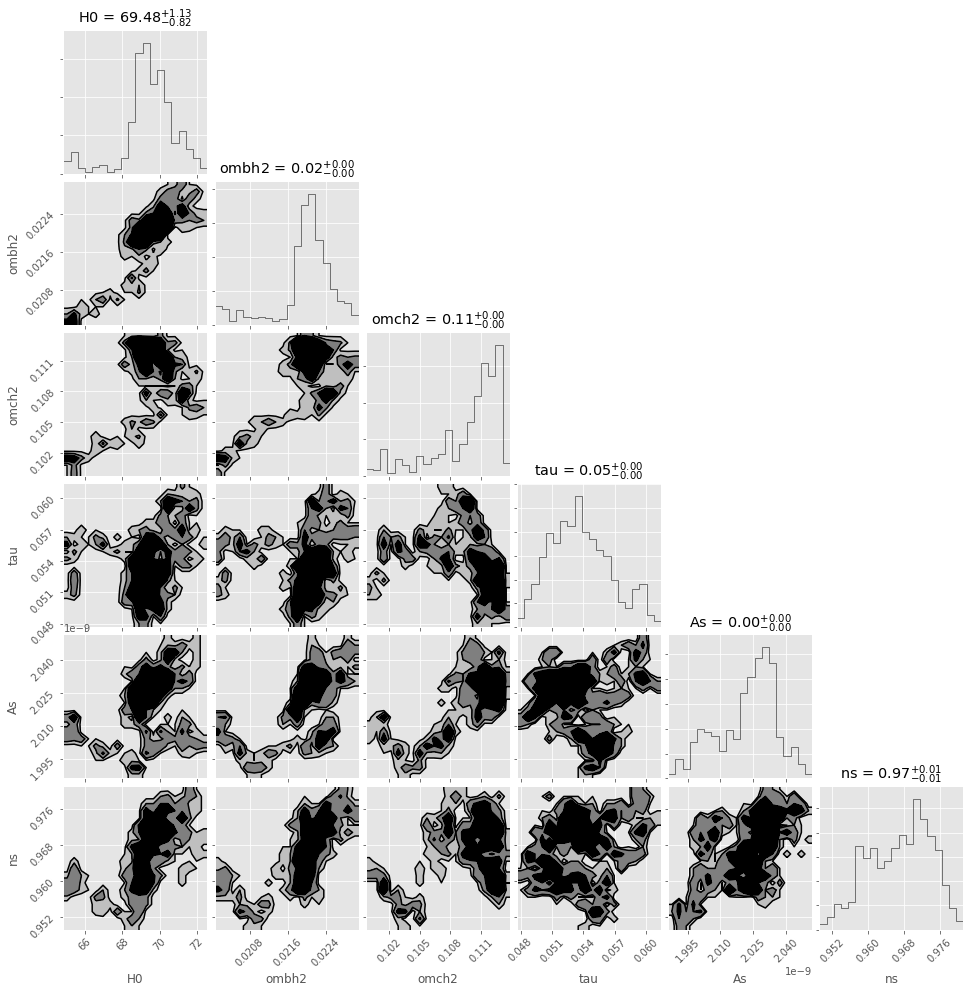

In [309]:

fit_params=np.mean(chains_new,axis=0)
print('the new parameters are', fit_params)

levels = (0.68,0.90,0.99)
labels = ["H0","ombh2","omch2","tau","As","ns" ]
weight_pars = np.loadtxt("weight_output", usecols = (0,1,2,3,4,5))
figure = corner.corner(weight_pars, show_titles=True,labels=labels, fill_contours=True, plot_datapoints=False, levels=levels,)

Using this method the params are:

$H_0$ = 69.48 $^{+1.13}_{-0.82}$

$\omega_b h^2$ = 0.020 $^{+0.00}_{-0.000}$

$\omega_c h^2$ = 0.11 $^{+0.00}_{-0.00}$

$\tau$ = 0.05 $^{+0.00}_{-0.00}$

$As$ ~ 2.0 $^{+0.1}_{-0.1}$ $\times 10^{-9}$

$ns$ = 0.97 $^{+0.01}_{-0.1}$



The values seem closer to the expected values and are closer to what is expected than what was found from weighting each parameter by the accepted tau value. These results seem more likely than the full chain results without the prior because the tau seemed to oscillate over a smaller range and was closer to the actual accepted value which would make the fit better and thus give a better approximation of our other parameters.